In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import pmdarima as pmd
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import operator
import random
pd.set_option('display.max_rows', 200)

/Users/lezhang/Documents/onecareer/onecareer-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load data

In [2]:
df = pd.read_csv("preprocessed_df.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.fillna(0)
print(df.shape)
df.head(2)

(476333, 19)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Weekly_Sales_to_fill,upper_bound,lower_bound,outlier,Weekly_Sales_to_fill_outlier
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,18535.48,33293.5925,6415.2525,False,24924.500
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,45561.85,52774.9225,39007.7825,False,35481.995


In [4]:
np.sum(df.isnull())

/Users/lezhang/Documents/onecareer/onecareer-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                           0
Dept                            0
Date                            0
Temperature                     0
Fuel_Price                      0
MarkDown1                       0
MarkDown2                       0
MarkDown3                       0
MarkDown4                       0
MarkDown5                       0
CPI                             0
Unemployment                    0
IsHoliday                       0
Weekly_Sales                    0
Weekly_Sales_to_fill            0
upper_bound                     0
lower_bound                     0
outlier                         0
Weekly_Sales_to_fill_outlier    0
dtype: int64

## Feature Engineering

In [5]:
# time features
df["year"] = df['Date'].dt.year
df["month"] = df['Date'].dt.month
df["week"] = df['Date'].dt.isocalendar().week

In [14]:
# add store data
df_store = pd.read_csv("stores.csv")
print(df_store.shape)
df_store.head()

(45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [15]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [16]:
# add store data
df = df.merge(df_store)
print(df.shape)
df.head()

(476333, 24)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Weekly_Sales_to_fill,upper_bound,lower_bound,outlier,Weekly_Sales_to_fill_outlier,year,month,week,Type,Size
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,18535.48,33293.5925,6415.2525,False,24924.500000,2010,2,5,A,151315
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,45561.85,52774.9225,39007.7825,False,35481.995000,2010,2,5,A,151315
2,1,3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,10366.85,18599.4650,2749.1850,False,37519.846667,2010,2,5,A,151315
3,1,4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,36579.96,43339.4025,29816.7425,False,35679.526667,2010,2,5,A,151315
4,1,5,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,21183.42,37175.6025,6450.7825,False,27608.996667,2010,2,5,A,151315


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Store                         476333 non-null  int64         
 1   Dept                          476333 non-null  int64         
 2   Date                          476333 non-null  datetime64[ns]
 3   Temperature                   476333 non-null  float64       
 4   Fuel_Price                    476333 non-null  float64       
 5   MarkDown1                     476333 non-null  float64       
 6   MarkDown2                     476333 non-null  float64       
 7   MarkDown3                     476333 non-null  float64       
 8   MarkDown4                     476333 non-null  float64       
 9   MarkDown5                     476333 non-null  float64       
 10  CPI                           476333 non-null  float64       
 11  Unemployment 

In [18]:
# Onehot encoding
# One-hot encode the month feature
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(df[['Type']])
encoded_df = pd.DataFrame(encoded, index=df.index, columns=[f'type_{i+1}' for i in range(encoded.shape[1])])

# Join the encoded features with the original dataframe
df = pd.concat([df, encoded_df], axis=1)
df.head(1)

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,lower_bound,outlier,Weekly_Sales_to_fill_outlier,year,month,week,Type,Size,type_1,type_2
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,6415.2525,False,24924.5,2010,2,5,A,151315,0.0,0.0


In [20]:
# convert previous 5 sales to features
df = df.sort_values(['Store','Dept','Date']).reset_index(drop=True)
for i in range(1,6):
    df[f'lag_{i}'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(i)
df.head(6)

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,week,Type,Size,type_1,type_2,lag_1,lag_2,lag_3,lag_4,lag_5
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,A,151315,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,...,6,A,151315,0.0,0.0,24924.50,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,...,7,A,151315,0.0,0.0,46039.49,24924.50,NaN,NaN,NaN
3,1,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,...,8,A,151315,0.0,0.0,41595.55,46039.49,24924.50,NaN,NaN
4,1,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,...,9,A,151315,0.0,0.0,19403.54,41595.55,46039.49,24924.50,NaN
5,1,1,2010-03-12,57.79,2.667,0.0,0.0,0.0,0.0,0.0,...,10,A,151315,0.0,0.0,21827.90,19403.54,41595.55,46039.49,24924.5


In [21]:
df.dropna(inplace=True)
print(df.shape)

(459678, 31)


In [22]:
# train and test split
date_to_split = df.Date.unique()[-5]
train = df[df.Date<date_to_split].reset_index(drop=True)
test = df[df.Date>=date_to_split].reset_index(drop=True)

In [23]:
# Prepare datasets for LightGBM
features = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'year', 'month', 'week', 'Size', 'type_1', 'type_2', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5']
X_train, y_train = train[features], train['Weekly_Sales']
X_test, y_test = test[features], test['Weekly_Sales']

## Develop a LightGBM model for all store and dept

In [24]:
# Configure and train the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm = lgb.train(params, train_data, num_boost_round=200)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 443023, number of used features: 21
[LightGBM] [Info] Start training from score 14174.204242


In [25]:
# Forecast the next 5 weeks
y_pred = gbm.predict(X_test)
test['pred'] = y_pred

133 5


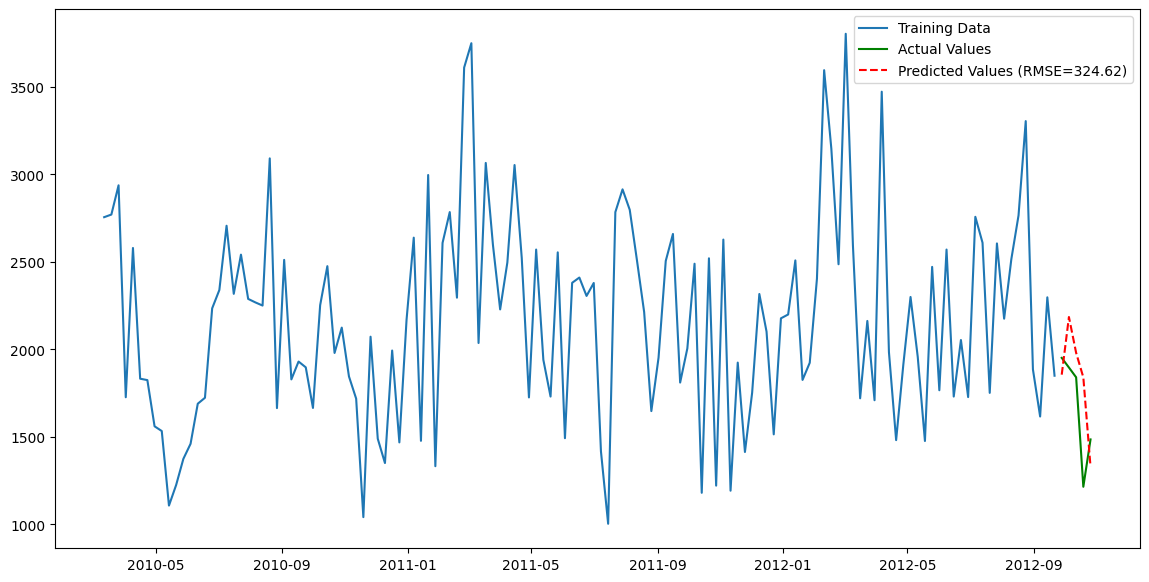

In [26]:
# plot for one store one Dept
plot_train = train[(train["Store"]==13)&(train["Dept"]==50)]
plot_test = test[(test["Store"]==13)&(test["Dept"]==50)]
rmse = np.sqrt(mean_squared_error(plot_test.Weekly_Sales, plot_test.pred))
print(plot_train.shape[0],plot_test.shape[0])

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(plot_train.Date, plot_train.Weekly_Sales, label='Training Data')
plt.plot(plot_test.Date, plot_test.Weekly_Sales, label='Actual Values', color='green')
plt.plot(plot_test.Date, plot_test.pred, label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()

## Fine tune the model

In [27]:
# Prepare datasets for LightGBM
features = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'year', 'month', 'week', 'Size', 'type_1', 'type_2', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5']
X, y = train[features], train['Weekly_Sales']

In [28]:
# function to do corss validation
def ts_cv(params, X, y, tscv):
    rmse_metrics = []
    mape_metrics = []
    # Perform Timeseries K-Fold Cross-Validation
    for train_index, valid_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_test = y[train_index], y[valid_index]
     
        # Create LightGBM datasets for training and testing
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
     
        # Train a LightGBM model
        num_round = 200
        bst = lgb.train(params, train_data, num_round)
     
        # Make predictions on the test set
        y_pred = bst.predict(X_test)
        
        # Calculate accuracy and store it in the metrics list
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse_metrics.append(rmse)
        mape_metrics.append(mape)
     
    # Calculate the average accuracy across all folds
    return bst, np.mean(rmse_metrics), np.mean(mape_metrics)

In [29]:
# function to do hyperparameter random search
def ts_random_search(param_grid, X, y, tscv, search_num, metric):
    metrics = []
    for i in range(search_num):
        params = {}
        for key in param_grid.keys():
            params[key] = random.choice(param_grid[key])
        #Train using selected parameters
        model, rmse, mape = ts_cv(params, X, y, tscv)
        metrics.append({"model": model,
                       "rmse": rmse,
                       "mape": mape,
                       "params": params})
    metrics.sort(key=operator.itemgetter(metric))
    return {"metrics": metrics,
              "best_model": metrics[0]["model"],
              "best_accuracy": metrics[0][metric],
              "best_params": metrics[0]["params"]}

In [36]:
param_grid = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [10, 100, 200],
    'learning_rate': [0.05, 0.01],
    'feature_fraction': [0.9],
    'min_data_in_leaf': [1, 5]
}
result = ts_random_search(param_grid=param_grid, X=X, y=y, tscv=TimeSeriesSplit(n_splits=5), search_num=3, metric='rmse')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3423
[LightGBM] [Info] Number of data points in the train set: 73838, number of used features: 20
[LightGBM] [Info] Start training from score 15808.464276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3553
[LightGBM] [Info] Number of data points in the train set: 147675, number of used features: 20
[LightGBM] [Info] Start training from score 16797.886729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

In [37]:
result

{'metrics': [{'model': <lightgbm.basic.Booster at 0x132d1d4f0>,
   'rmse': 4459.70301784324,
   'mape': 735400637748643.2,
   'params': {'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5}},
  {'model': <lightgbm.basic.Booster at 0x132d1edc0>,
   'rmse': 4541.41013603367,
   'mape': 628073305476935.0,
   'params': {'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 1}},
  {'model': <lightgbm.basic.Booster at 0x132c878b0>,
   'rmse': 5526.658109338674,
   'mape': 2.0083421109826696e+16,
   'params': {'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 1}}],
 'best_model': <lightgbm.basic.Booster at 0x132d1d4f0>,
 'best_accuracy': 4459.70301784324,
 'best_params': {'objective': 'regression

133 5


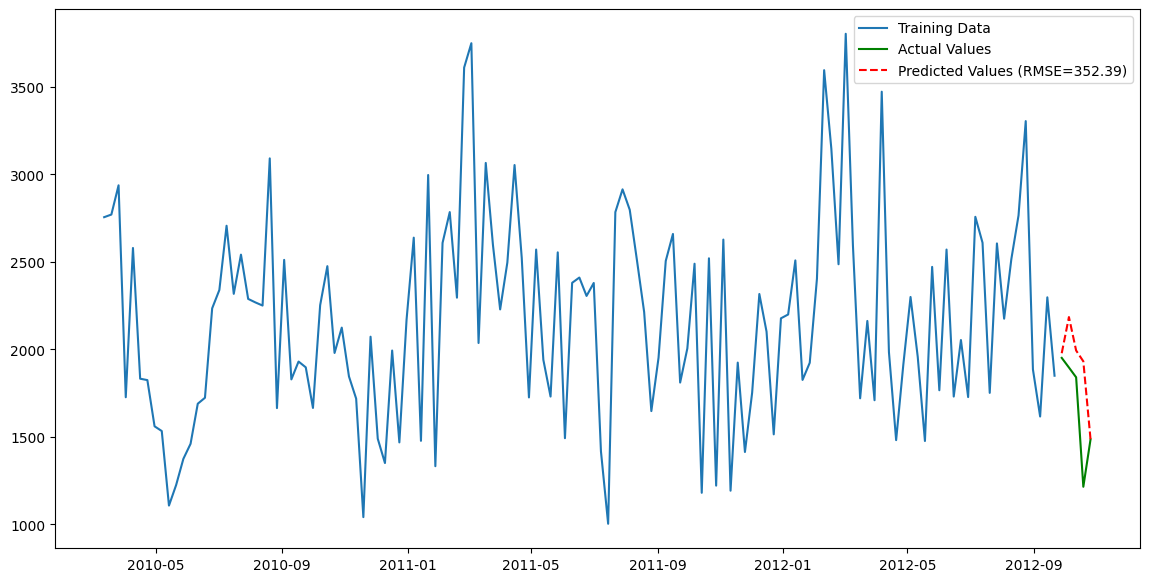

In [38]:
# plot for one store one Dept
plot_train = train[(train["Store"]==13)&(train["Dept"]==50)]
plot_test = test[(test["Store"]==13)&(test["Dept"]==50)]
y_pred = result['best_model'].predict(plot_test[features])

rmse = np.sqrt(mean_squared_error(plot_test.Weekly_Sales, y_pred))
print(plot_train.shape[0],plot_test.shape[0])

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(plot_train.Date, plot_train.Weekly_Sales, label='Training Data')
plt.plot(plot_test.Date, plot_test.Weekly_Sales, label='Actual Values', color='green')
plt.plot(plot_test.Date, y_pred, label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()